# **Intro**
**Supervised Learning**

Date Range: **Sep 2021 to March 2022**

Techniques: **Linear Regression, KNN, Neural Network**

- Target    = **Recovery cases**
- Feature   = **Date, vaccination, case_new, case_active, case_unvax, case_fvax**




# **Prerequisite**

In [25]:
import random
import time
import csv

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# TensorFlow
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

# **Loading DataSet from Github**

In [26]:
# URL should be https://raw.githubusercontent.com/username/repository/branch/filename.csv so no download needed

# Cases & Info: https://github.com/MoH-Malaysia/covid19-public/tree/main/epidemic/{specific_file}
# Vaccination : https://github.com/CITF-Malaysia/citf-public/tree/main/vaccination/{specific_file}

url_cases = "https://raw.githubusercontent.com/MoH-Malaysia/covid19-public/main/epidemic/cases_malaysia.csv"
url_vax = "https://raw.githubusercontent.com/CITF-Malaysia/citf-public/main/vaccination/vax_malaysia.csv"


In [27]:
# Reading CSV files from URL
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

columnsCases = ['date', 'cases_new', 'cases_active', 'cases_unvax', 'cases_fvax', 'cases_recovered']
columnsVax = ['date', 'daily']

df_cases = pd.read_csv(url_cases, usecols=columnsCases)
df_vax = pd.read_csv(url_vax, usecols=columnsVax)

start = '2021-09-01'
end = '2022-03-01'

df_cases = df_cases[(df_cases['date'] >= start) & (df_cases['date'] <= end)]
df_vax = df_vax[(df_vax['date'] >= start) & (df_vax['date'] <= end)]
df_combined = pd.merge(df_cases, df_vax, on='date')

# print(df_cases.to_string(index=False))
# print(df_vax.to_string(index=False))
print(df_combined.to_string(index=False))

      date  cases_new  cases_recovered  cases_active  cases_unvax  cases_fvax  daily
2021-09-01      18762            21073        265279         8299        5487 431749
2021-09-02      20988            23473        262545         9557        6263 405408
2021-09-03      19378            22399        259194         8598        6015 359964
2021-09-04      19057            21582        256307         8308        6213 336857
2021-09-05      20396            20573        255794         8852        6875 317247
2021-09-06      17352            20201        252673         7306        5969 343995
2021-09-07      18547            18902        252007         8142        6134 352471
2021-09-08      19733            22701        248678         8191        7017 352293
2021-09-09      19307            24855        242808         8020        6930 353959
2021-09-10      21176            21476        242167         8437        7964 318262
2021-09-11      19550            21771        239354         8187

# **Linear Regression**

Test Loss: 0.4632244813415065
Validation Mean Square Error: 1641929.5296346173
Test Mean Square Error: 28143098.098236978


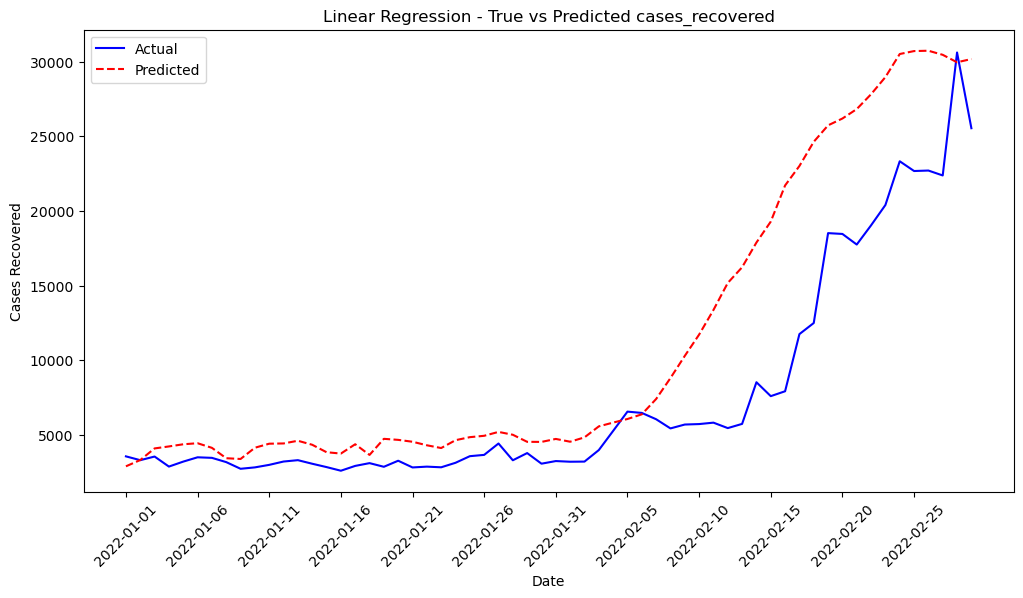

In [28]:
# Linear Regression
train_data = df_combined[(df_combined['date'] >= '2021-09-01') & (df_combined['date'] <= '2021-12-31')]
test_data = df_combined[(df_combined['date'] >= '2022-01-01') & (df_combined['date'] <= '2022-03-01')]

X_train = train_data[['daily', 'cases_new', 'cases_active', 'cases_unvax', 'cases_fvax']]
y_train = train_data['cases_recovered']

X_test = test_data[['daily', 'cases_new', 'cases_active', 'cases_unvax', 'cases_fvax']]
y_test = test_data['cases_recovered']

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Using sklearn linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Calculate R2 Score
test_loss = model.score(X_test, y_test)
print(f'Test Loss: {test_loss}')

# Evaluate the model on the validation set
val_predictions = model.predict(X_val)
val_mse = mean_squared_error(y_val, val_predictions)
print(f'Validation Mean Square Error: {val_mse}')

# Evaluate the model on the test set
test_predictions = model.predict(X_test)
test_mse = mean_squared_error(y_test, test_predictions)
print(f'Test Mean Square Error: {test_mse}')

# Plot the predictions and the actual values in date domain
plt.figure(figsize=(12, 6))
plt.plot(test_data['date'], y_test, label='Actual', color='blue')
plt.plot(test_data['date'], test_predictions, label='Predicted', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Cases Recovered')
plt.title('Linear Regression - True vs Predicted cases_recovered')

n = len(y_test)
dates_aligned = df_combined['date'].iloc[-n:]
tick_interval = 5
plt.xticks(ticks=dates_aligned[::tick_interval], labels=dates_aligned[::tick_interval], rotation=45)


plt.legend()
plt.show()


# **KNN Regression**

Test Loss: 0.7765125547910945
Validation Mean Squared Error: 1462270.8375
Test Mean Squared Error: 11717429.121875


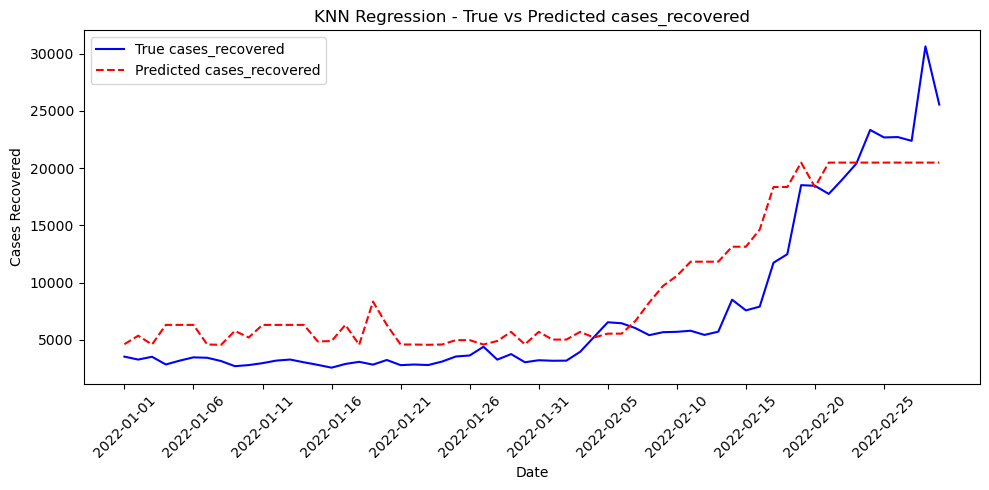

In [29]:
# KNN

# Prepare the features and target for KNN regression
features = ['daily', 'cases_new', 'cases_active', 'cases_unvax', 'cases_fvax']
target = 'cases_recovered'

# Splitting the data into training + validation
training_validation_df = df_combined[df_combined['date'] < '2021-12-31']
testing_df = df_combined[(df_combined['date'] >= '2022-01-01') & (df_combined['date'] <= '2022-03-01')]
X_test = testing_df[features]
y_test = testing_df[target]
# Further split training_validation_df into training and validation sets (80-20 split)
X_train_val = training_validation_df[features]
y_train_val = training_validation_df[target]

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Initialize and fit the KNN regressor
knn = KNeighborsRegressor(n_neighbors=4)  # You can experiment with different n_neighbors
knn.fit(X_train, y_train)

# Evaluate the model
test_loss = knn.score(X_test, y_test)
print(f'Test Loss: {test_loss}')

# Validate the model on the validation set
y_val_pred = knn.predict(X_val)
val_mse = mean_squared_error(y_val, y_val_pred)
print(f"Validation Mean Squared Error: {val_mse}")

# Predicting cases_recovered for the testing set

y_test_pred = knn.predict(X_test)

# Calculate the Mean Squared Error (MSE) for the test prediction
test_mse = mean_squared_error(y_test, y_test_pred)
print(f"Test Mean Squared Error: {test_mse}")

# Plotting the true vs predicted values for cases_recovered
plt.figure(figsize=(10, 5))
plt.plot(testing_df['date'], y_test, label='True cases_recovered', color='blue')
plt.plot(testing_df['date'], y_test_pred, label='Predicted cases_recovered', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Cases Recovered')
plt.title('KNN Regression - True vs Predicted cases_recovered')
plt.legend()

n = len(y_test)
dates_aligned = df_combined['date'].iloc[-n:]
tick_interval = 5
plt.xticks(ticks=dates_aligned[::tick_interval], labels=dates_aligned[::tick_interval], rotation=45)

plt.tight_layout()
plt.show()


# **Neural Network**

Epoch 1/100


C:\Users\User\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 721856768.0000 - val_loss: 45081732.0000
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 64527560.0000 - val_loss: 14529687.0000
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 27460410.0000 - val_loss: 7871706.0000
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 26776728.0000 - val_loss: 5217799.5000
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 21216550.0000 - val_loss: 7729963.5000
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 10627803.0000 - val_loss: 10107804.0000
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 12815341.0000 - val_loss: 9643475.0000
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 12616593.0000 - val_loss: 15649413.0000
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 13005622.0000 - val_loss: 15766144.0000
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 11400568.0000 - val_loss: 8422168.0000
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8m

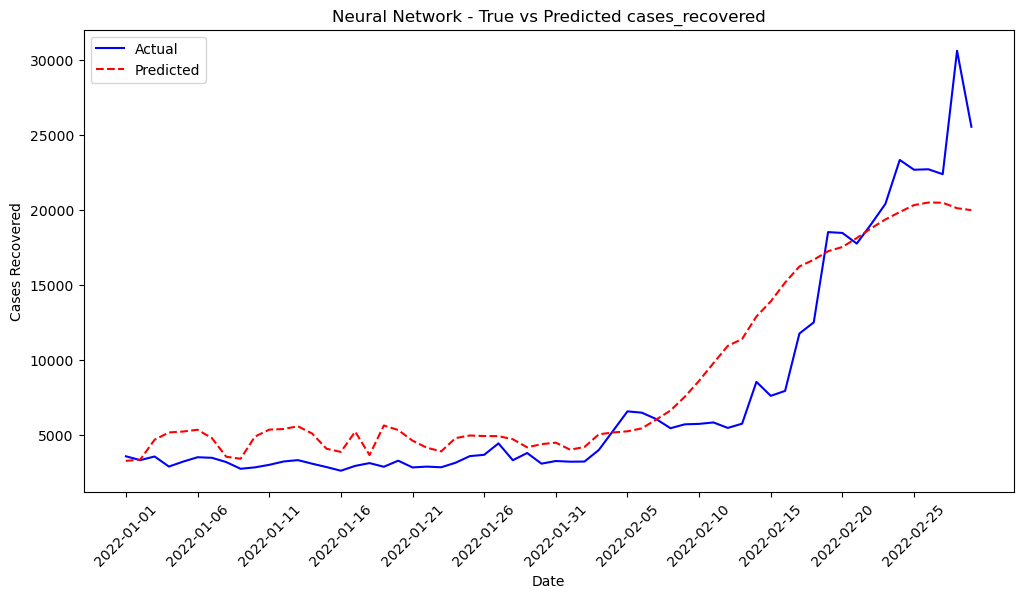

In [30]:
# Neural Network
train_data = df_combined[(df_combined['date'] >= '2021-09-01') & (df_combined['date'] <= '2021-12-31')]
test_data = df_combined[(df_combined['date'] >= '2022-01-01') & (df_combined['date'] <= '2022-03-01')]

X_train = train_data[['daily', 'cases_new', 'cases_active', 'cases_unvax', 'cases_fvax']]
y_train = train_data['cases_recovered']

X_test = test_data[['daily', 'cases_new', 'cases_active', 'cases_unvax', 'cases_fvax']]
y_test = test_data['cases_recovered']

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# -----------------------------------------------------------------------------------
# TensorFlow model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(5,)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1)
])


model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val))

# Evaluate the model
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

# Make predictions
predictions = model.predict(X_test)

# r2
r2 = r2_score(y_test, predictions)
print("R2 score: ", r2)

# -----------------------------------------------------------------------------------

# Plot the predictions and the actual values in date domain
plt.figure(figsize=(12, 6))
plt.plot(test_data['date'], y_test, label='Actual', color='blue')
plt.plot(test_data['date'], predictions, label='Predicted', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Cases Recovered')
plt.title('Neural Network - True vs Predicted cases_recovered')

n = len(y_test)
dates_aligned = df_combined['date'].iloc[-n:]
tick_interval = 5
plt.xticks(ticks=dates_aligned[::tick_interval], labels=dates_aligned[::tick_interval], rotation=45)

plt.legend()
plt.show()
